In [40]:
import torch
import numpy as np
import scipy.io as sio
import os

In [41]:
if torch.cuda.is_available():
   device = torch.device("cuda")
   print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [51]:
# Paramètres du modèle
N = 2 # dim de l'input x
m = 10 # dim de l'output y
T = 1 # borne sup pour x
nb_points = 10 
nb_maps = 100 # nombre d'images que l'on va générer
nb_blocks = 2 # nombre de blocs dans le modèle
M = 10 # nombre d'échantillons pour l'approximation de Monte Carlo

In [43]:
omega = torch.tensor([[0, 1] for _ in range(N)])
X = torch.zeros((nb_maps, nb_points, N))

for _ in range(nb_maps):
    x = torch.rand(nb_points, N) * (omega[:, 1] - omega[:, 0]) + omega[:, 0] # all the coordinates of x are between 0 and 1
    X[_, :, :] = x
X = torch.Tensor(np.expand_dims(X, axis=1))
print(f'La dimension de x est {x.size()}')

La dimension de x est torch.Size([10, 2])


In [44]:
class Block(torch.nn.Module):
    def __init__(self, m) -> None:
        super(Block, self).__init__()
        self.fc = torch.nn.Linear(m, m)
        self.activation = torch.nn.Tanh()

    def forward(self, x):
        identity = x
        x = self.fc(x)
        x = self.activation(x)
        x = self.fc(x)
        x = self.activation(x)
        return x + identity
    
class Model(torch.nn.Module):
    def __init__(self, N, m, nb_blocks) -> None:
        super(Model, self).__init__()
        self.fc_in = torch.nn.Linear(N, m)
        self.blocks = torch.nn.ModuleList([Block(m) for _ in range(nb_blocks)])
        self.fc_out = torch.nn.Linear(m, m)

    def forward(self, x):
        x = self.fc_in(x)
        for block in self.blocks:
            x = block(x)
        x = self.fc_out(x)
        return x

In [45]:
def conv(x : torch.Tensor, dx = True, delta : float = 1/nb_points) -> torch.Tensor:
    if dx:
        convx = torch.zeros(x.shape)
        for i in range(x.shape[0]):
            for j in range(x.shape[1]):
                if j == 0 :
                    convx[i, j] = (x[i, j+1] - x[i, j])/delta # forward 
                elif j == x.shape[1] - 1:
                    convx[i, j] = (x[i, j] - x[i, j-1])/delta # backward
                else:
                    convx[i, j] = (x[i, j+1] - x[i, j-1])/(2*delta) # central
        return convx
    else:
        convy = torch.zeros(x.shape)
        for i in range(x.shape[0]):
            for j in range(x.shape[1]):
                if i == 0 :
                    convy[i, j] = (x[i+1, j] - x[i, j])/delta # forward
                elif i == x.shape[0] - 1:
                    convy[i, j] = (x[i, j] - x[i-1, j])/delta # backward
                else:
                    convy[i, j] = (x[i+1, j] - x[i-1, j])/(2*delta) # central
        return convy
        
# def impose_BC(x : torch.Tensor) -> torch.Tensor:
#     x[:, -1] = torch.Tensor(np.cos(2 * np.pi * x[-1, :].detach().numpy()))
#     x[:, 0], x[0, :-1], x[-1, :-1] = 1., 1., 1.
#     return x

In [46]:
source_term = sio.loadmat('source_term.mat')
u = sio.loadmat('u.mat')

source_term = torch.Tensor(np.expand_dims(source_term['source_term'], axis=1))
u = torch.Tensor(np.expand_dims(u['u'], axis=1))

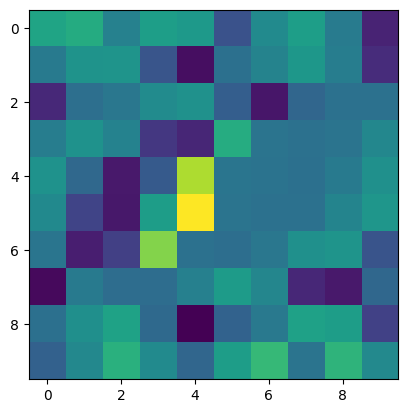

In [47]:
import matplotlib.pyplot as plt
plt.imshow(source_term[0, 0, :, :])

In [52]:
# Code simple pour une seule image
lr = 1e-4
beta_1 = 0.5
beta_2 = 0.999

gen = Model(N, m, nb_blocks)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
source_term_0 = impose_BC(source_term[0, 0, :, :])

cur_steps = 0
# Monte Carlo
# for _ in range(10) :

output = gen(torch.rand(nb_points, N))

while np.linalg.norm(output.detach().numpy() - source_term[0, 0, :, :].detach().numpy()) > 1e-1:
    gen_opt.zero_grad()

    output = gen(x)
    
    mc_index = torch.randperm(nb_points)[:M]
    output_mc = output[mc_index, :]
    source_term_mc = source_term_0[mc_index, :]

    output_dx, output_dy = conv(output_mc), conv(output_mc, dx = False)
    L1, L2 = torch.pow(output_dx, 2), torch.pow(output_dy, 2)
    L1, L2 = torch.sum(L1)/(L1.shape[0]*L1.shape[1]), torch.sum(L2)/(L2.shape[0]*L2.shape[1])
    L3 = torch.sum(source_term_mc*output_mc) / (source_term_mc.shape[0]*source_term_mc.shape[1])

    loss = (L1 + L2)/2 - L3 
    loss.backward()
    gen_opt.step()
    cur_steps += 1
    # print(f'Loss : {loss}')
    print(np.linalg.norm(output.detach().numpy() - source_term[0, 0, :, :].detach().numpy()))
plt.imshow(output.detach().numpy())
plt.show()
print(np.linalg.norm(output - source_term[0, 0, :, :]))

224.41475
224.41463
224.41454
224.41443
224.41434
224.41423
224.41414
224.41405
224.414
224.4139
224.41383
224.41373
224.41364
224.41354
224.41348
224.41339
224.41333
224.41324
224.41316
224.41306
224.41298
224.41287
224.41281
224.41278
224.41275
224.4127
224.41264
224.41258
224.41252
224.41248
224.41241
224.41235
224.41234
224.41228
224.41222
224.41214
224.4121
224.41203
224.41202
224.412
224.41194
224.41187
224.41179
224.41173
224.41167
224.41159
224.4115
224.41145
224.41138
224.41132
224.41129
224.41121
224.41113
224.41113
224.41112
224.41107
224.41101
224.41095
224.41089
224.41087
224.41081
224.4108
224.41074
224.41064
224.41061
224.41055
224.41052
224.41046
224.41042
224.41032
224.41026
224.41026
224.41022
224.41017
224.41011
224.41005
224.40999
224.40996
224.40993
224.4099
224.40984
224.40982
224.40977
224.40971
224.4097
224.40965
224.40959
224.40956
224.40952
224.40952
224.40947
224.40945
224.4094
224.40933
224.40926
224.4092
224.40918
224.4092
224.40918
224.40912
224.4091
224.4

KeyboardInterrupt: 

In [ ]:
# Code pour le tenseur complet
lr = 1e-4
beta_1 = 0.5
beta_2 = 0.999

gen = Model(N, m, nb_blocks)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))

cur_steps = 0
# Monte Carlo
# for _ in range(10) :

output = gen(torch.rand(nb_maps, 1, nb_points, nb_blocks))

while np.linalg.norm(output.detach().numpy() - source_term.detach().numpy()) > 1e-1:
    gen_opt.zero_grad()
    
    output = gen(X)
    output_dX, output_dY = torch.zeros(output.shape), torch.zeros(output.shape)
    for i, out in enumerate(output) :
        output_dx, output_dy = conv(out[0]), conv(out[0], dx = False)
        output_dx, output_dy = output_dx.expand(1, 1, -1, -1), output_dy.expand(1, 1, -1, -1)
        output_dX[i, :, :, :], output_dY[i, :, :, :] = output_dx, output_dy

    L1, L2 = torch.pow(output_dX, 2), torch.pow(output_dY, 2)
    L1, L2 = torch.sum(L1)/(L1.shape[0]*L1.shape[1]), torch.sum(L2)/(L2.shape[0]*L2.shape[1])
    L3 = torch.sum(source_term*output) / (source_term.shape[0]*source_term.shape[1])

    loss = (L1 + L2)/2 - L3
    loss.backward()
    gen_opt.step()
    cur_steps += 1
    # print(f'Loss : {loss}')
    print(np.linalg.norm(output.detach().numpy() - source_term[0, 0, :, :].detach().numpy()))
plt.imshow(output.detach().numpy())
plt.show()
print(np.linalg.norm(output - source_term[0, 0, :, :]))

764.7393
764.7283
764.7172
764.7063
764.6954
764.6844
764.6736
764.6628
764.652
764.6411
764.6304
764.6196
764.60895
764.59827
764.58765
764.577
764.5664
764.55585
764.5452
764.5347
764.52423
764.5138
764.5033
764.49274
764.48236


KeyboardInterrupt: 

In [ ]:
gen = Model(N, m, nb_blocks)
output = gen(X)
output_dX, output_dY = torch.zeros(output.shape), torch.zeros(output.shape)

for i, out in enumerate(output) :
    output_dx, output_dy = conv(out[0]), conv(out[0], dx = False)
    output_dx, output_dy = output_dx.expand(1, 1, -1, -1), output_dy.expand(1, 1, -1, -1)
    output_dX[i, :, :, :], output_dY[i, :, :, :] = output_dx, output_dy
    
L1, L2 = torch.pow(output_dX, 2)/2, torch.pow(output_dY, 2)/2
# gen_opt = torch.optim.Adam(gen.parameters(), lr=1e-4)